<a href="https://colab.research.google.com/github/omerahmed12345elhussien/RL_Project_Car_Racing/blob/omer%2Fadded-files/DQN_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Deep Q-Network

In this notebook, we implement the DQN agent on the <a href="https://gymnasium.farama.org/environments/box2d/car_racing/">Car-Racing v0 </a> environment, as a first part of our project.


## Installation

In [1]:
#@title Installations  { form-width: "30%" }

%pip install git+https://github.com/deepmind/acme.git#egg=dm-acme[jax,tf,envs]

from IPython.display import clear_output
clear_output()

In [2]:
%pip install swig
%pip install gymnasium[box2d]
%pip install --upgrade dopamine-rl
%pip install --upgrade gym
%pip install stable-baselines3[extra]
%pip install gym-notebook-wrapper
%pip install wandb
%pip install xvfbwrapper
!sudo apt-get install xvfb#
!pip install xvfbwrapper
from IPython.display import clear_output
clear_output()

In [ ]:
!git clone https://github.com/omerahmed12345elhussien/RL_Project_Car_Racing.git
%cd RL_Project_Car_Racing
from car_racing import *
clear_output()

In [4]:
#@title Imports  { form-width: "30%" }

import IPython

import base64
import chex
import collections
from collections import namedtuple
import dm_env
import enum
import functools
import gym
import haiku as hk
import io
import itertools
import jax
from jax import tree_util
import optax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
#import reverb
import rlax
import time
from bsuite import environments
from typing import Callable,Dict
import tree

from matplotlib import animation
from IPython.display import HTML
import cv2
# Filter out warnings as they are distracting.
import warnings
warnings.filterwarnings('ignore')

np.set_printoptions(precision=3, suppress=1)

%matplotlib inline
seed_value = 0  # @param

## 1. Environment

In [ ]:
# @title Random policy  { form-width: "30%" }
def random_policy(obs: chex.Array, num_actions: int) -> chex.Array:
  return np.random.randint(num_actions)

Observation space:  Box(0, 255, (96, 96, 3), uint8)
Action space:  Discrete(5)


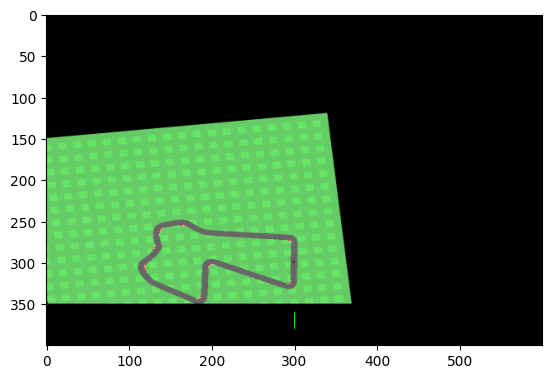

In [6]:
env = CarRacing_Disc("rgb_array")
print("Observation space: ", env.observation_space)
print("Action space: ", env.action_space)
env.reset()
env.render()
im = env.render()
plt.imshow(im)

During the first 50 steps of the game, the camera zoom-in. We can move the car during this period of zooming, but it will affect the agent's learning process. So, the first 50 steps will be excluded during the training stage.

AxesImage(size=(96, 96))
End of episode
Final reward: -132.142857142853


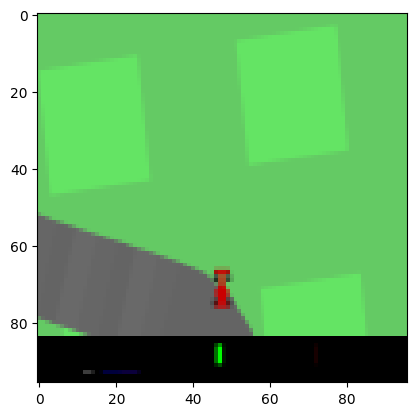

In [16]:
# @title Interacting with the environment.
num_episodes = 1 # @param

environment = CarRacing_Disc("rgb_array")#

int2action = {0: "do nothing", 1: "left", 2: "right",3:"gas",4:"brake"}
Na = environment.action_space.n


for episode in range(num_episodes):

  # Reset any counts and start the environment.
  s = environment.reset()[0]
  total_reward = 0.0
  frames = []
  #To make the camera zoom-in for the first 50 steps of the game.
  for _ in range(50):
    s, r, terminated, truncated, info = environment.step(0)
    frames.append(s)

  # Run an episode.
  for _ in range(2000):
    # Generate an action from the agent's policy and step the environment.
    action = random_policy(environment.state, Na)
    s, r, terminated, truncated, info = environment.step(action)
    frames.append(s)
    total_reward += r

print(plt.imshow(s))
print("End of episode")
print("Final reward:", total_reward)

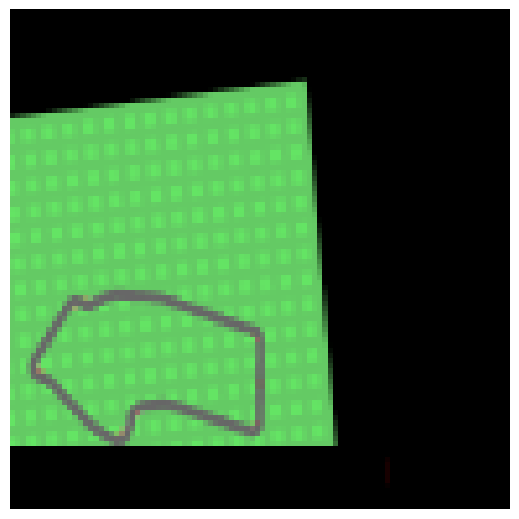

In [19]:
# @title Create Animation for the random policy.
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
plt.axis('off')
im = plt.imshow(frames[0])
def animate(i):
    im.set_array(frames[i])
    return im
anim = animation.FuncAnimation(fig, animate, frames=1000)
HTML(anim.to_html5_video())
#Save animation to .gif file.
anim.save('animation_interaction.gif',writer='pillow')

### Preprocessing

First, we preprocess the given frame by converting it to gray-scale, and down-sample it to a 110x84 image. Then, we crop an 84x84 region of the image that roughly captures the playing zone.

In the case of <a href="https://gymnasium.farama.org/environments/box2d/car_racing/">car-racing</a>, we benefit from our knowledge that all the frames have black area at the bottom, so we remove that part from our final frame.
Morevoer, we stack 4 frames as our input to the Q-function. Also, we apply the same action on these stacked frames.

In [7]:
def process_state_image(obs: chex.Array) -> chex.Array:
  """
  process_state_image() processes the given frame obs from Car-Racing environment to gray-scale with (84x84) dimension.
  Input: state image of size (96,96)
  Output: gray-scale image of size (84,84)
  """
  obs = obs[:84, 6:90]
  return cv2.cvtColor(obs,cv2.COLOR_BGR2GRAY)/255.0

In [8]:
class ModifImage(gym.Wrapper):
  """
  Implementation of Image preprocessing.
  """
  def __init__(self,env, skip_frames: int =4, num_stack_frame:int = 4,**kwargs)-> None:
    """
    Initialize an Image preprocessing object.

    Args:
      skip_frames: the number of frames we skip.
      num_stack_frame: the number of frames we stck together as a single state.
    """
    super(ModifImage,self).__init__(env,**kwargs)
    self.skip_frames = skip_frames
    self.num_stack_frame = num_stack_frame

  def reset(self)-> tuple[chex.Array, Dict]:
    #Reset the environment.
    s, info = self.env.reset()
    #Skipp the first 50 steps
    for _ in range(50):
      s, r, terminated, truncated, info = self.env.step(0)
    #Convert the state to size (84,84).
    s = process_state_image(s)
    #Create a stack of the skipped frames of size (4,84,84).
    self.stacked_frames  = np.tile(s, (self.num_stack_frame,1,1))
    return self.stacked_frames , info

  def step(self,action: chex.Array) -> tuple[chex.Array,chex.Array,chex.Array,chex.Array, Dict]:
    #Compute actions for the skipped frames.
    reward  = 0.0
    for _ in range(self.skip_frames):
      s, r, terminated, truncated, info = self.env.step(action)
      reward += r
      if terminated or truncated: break
    #Convert the state to size (84,84).
    s = process_state_image(s)
    self.stacked_frames = np.concatenate((self.stacked_frames[1:],s[None]),axis = 0)
    return self.stacked_frames,reward,terminated,truncated, info


Image shape:(4, 84, 84) 


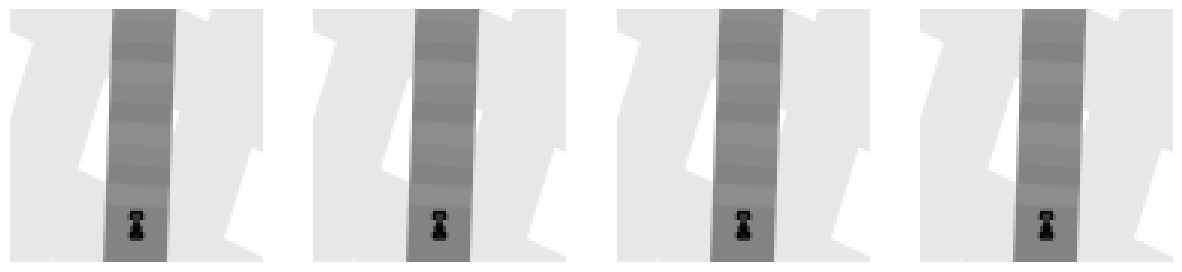

In [37]:
env = CarRacing_Disc("state_pixels")
env = ModifImage(env)

s, _ = env.reset()
print(f"Image shape:{s.shape} ")

fig, axes = plt.subplots(1, 4, figsize=(15, 10))
for i in range(4):
    axes[i].imshow(s[i], cmap='gray')
    axes[i].axis('off')
plt.show()

## 2. Deep Q-Learning

### 2.1. Implementing a uniform replay buffer

In [19]:
#@title Uniform Replay Buffer { form-width: "30%" }

@chex.dataclass
class Transition:
  observation: chex.Array
  action: chex.Array
  reward: chex.Array
  done: chex.Array
  next_observation: chex.Array


class ReplayBuffer:
  """Fixed-size buffer to store transition tuples."""

  def __init__(self, buffer_capacity: int):
      """Initialize a ReplayBuffer object.
      Args:
          buffer_capacity (int): maximum allowed size of the replay buffer.
      """
      self._memory = collections.deque(maxlen=buffer_capacity)
      self._maxlen = buffer_capacity
      self._count_idx = 0

  @property
  def size(self) -> int:
    # Return the current number of elements in the buffer.
    return len(self._memory)

  def add(self, transition: Transition) -> None:
      """Add a new transition to memory."""
      self._memory.append(transition)

  def sample_batch(self, batch_size: int) -> Transition:
    """Randomly sample a batch of experiences from memory."""
    assert len(self._memory) >= batch_size, 'Insuficient number of transitions in replay buffer'

    indices = np.random.randint(self.size,size=(batch_size,))
    transitions: list[Transition] = [self._memory[i] for i in indices]
    return tree.map_structure(lambda *x: np.stack(x),*transitions)
    #transitions: list[Transition] = random.choices(self._memory, k=batch_size)
    #return tree.map_structure(lambda *x: np.stack(x), *transitions)

In [20]:
# @title Test the replay buffer
env = CarRacing_Disc("state_pixels")
env = ModifImage(env)

env = ModifImage(CarRacing_Disc("state_pixels"))
batch_size = 32
buffer = ReplayBuffer(100)
ts,_ = env.reset()
for _ in range(50):
  s, r, terminated, truncated, info = env.step(0)

  buffer.add(
      Transition(
          observation=ts,
          action=0,
          reward=r,
          done=terminated,
          next_observation=s,
      )
  )
  ts = s

assert buffer.sample_batch(batch_size).observation.shape[0] == batch_size

### 2.2. Implementing a Car-Racing Network

The input to the neural network is a 84x84x4 image. The first layer convolves 16 (8x8) filters with stride 4 with the input image and applies a ReLU. The second hidden layers convolves 32 (4x4) filters with stride 2, again followed by ReLU. The final hidden layer is fully-connected and consists of 256 rectifier units. The output layer is a fully connected linear layer with a single output for each valid action.


In [10]:
#@title **[1. Car-Racing Network]**  { form-width: "30%" }
env = ModifImage(CarRacing_Disc("state_pixels"))
num_actions = env.action_space.n

def car_network(x: chex.Array) -> chex.Array:
  """Implenentation of Car-Racing network"""
  network = hk.Sequential(
      [
          hk.Conv2D(16,kernel_shape=(8,8),stride=(4,4)), # [N, 4, 84, 84] -> [N, 16, 20, 20]
          jax.nn.relu,
          hk.Conv2D(32,kernel_shape=(4,4),stride=(2,2)),  # [N, 16, 20, 20] -> [N, 32, 9, 9]
          jax.nn.relu,
          hk.Flatten(), #[N, 32*9*9]
      ]
  )
  out = network(x)
  out = hk.Linear(256)(out)
  #out = jax.nn.relu(out)
  out = hk.Linear(num_actions)(out)
  return out

Also, we implemented another architecture:
- The first layer convolves 32 (8x8) filters with stride (4x4) and padding; then applies a ReLU.
- The second layer convolves 64 (4x4) filters with stride (2X2) and padding; then applies a ReLU.
- The third layer convolves 64 (3x3) filters with stride (1X1) and padding; then applies a ReLU.
- Then, we Flatten all the dimensions except the batch dimension.
- The fourth layer is a fully connected linear layer of 512 nodes; then applies a ReLU.
- The output layer is a fully connected linear layer with a single output for each valid action.

In [ ]:
#@title **[2. Car-Racing Network]**  { form-width: "30%" }

def car_network(x: chex.Array):
  """Implenentation of Car-Racing network"""
  network = hk.Sequential(
      [
          hk.Conv2D(32,kernel_shape=(8,8),stride=(4,4),padding='VALID'),
          jax.nn.relu,
          hk.Conv2D(64,kernel_shape=(4,4),stride=(2,2),padding='VALID'),
          jax.nn.relu,
          hk.Conv2D(64,kernel_shape=(3,3),stride=(1,1),padding='VALID'),
          jax.nn.relu,
          hk.Flatten(),
      ]
  )
  out = network(x)
  out = hk.Linear(512)(out)
  out = jax.nn.relu(out)
  out = hk.Linear(num_actions)(out)
  return out

### 2.3. Implementing a DQN agent

In [11]:
#@title **[DQN agent]**

@chex.dataclass
class LearnerState:
  """"Container for all variables needed for training."""
  online_params: hk.Params
  target_params: hk.Params
  opt_state: optax.OptState

class DQNAgent:
  """Implementation of the DQN agent."""

  def __init__(
      self,
      init_params_fn: Callable[[jax.random.KeyArray], hk.Params],
      network_apply_fn: Callable[[hk.Params, chex.Array], chex.Array],
      optimizer: optax.GradientTransformation,
      gamma: float,
      epsilon: float,
      num_actions: int,
      buffer_capacity: int,
      batch_size: int,
      target_ema: float,
      epsilon_min=0.05,
      seed: int = seed_value,
  ) -> None:
    """Initializes the DQN agent.

    Args:
      init_params_fn: the pure function which initializes the network parameters.
      network_apply_fn: the pure function corresponding to the desired DQN network.
      optimizer: the optimizer used to minimize the DQN loss.
      gamma: the agent's discount factor.
      epsilon: probability to perform a random exploration when picking a new action.
      num_actions: number of actions in the environment's action space.
      buffer_capacity: capacity of the replay buffer.
      batch_size: batch size when updating the online network.
      target_ema: coefficient for the exponential moving average computation of
        the target network parameters.
      seed: seed of the random generator.
    """
    self._gamma = gamma
    self._epsilon = epsilon
    self._num_actions = num_actions
    self._batch_size = batch_size
    self._target_ema = target_ema
    self.total_steps = 0 #Total number of interaction with the environment.
    self.warm_up = 5000
    self.epsilon_decay = (epsilon - epsilon_min) / 1e6

    # Set the neural network and optimizer.
    self._network_apply_fn = network_apply_fn
    self._optimizer = optimizer

    # Initialize the replay buffer.
    self._buffer = ReplayBuffer(buffer_capacity)

    # Always store the current observation so we can create transitions.
    self._observation = None

    # Initialize the network's parameters.
    params = init_params_fn(jax.random.PRNGKey(seed))

    # Initialize the learner state.
    self._learner_state = LearnerState(
        online_params=params,
        target_params=jax.tree_map(jnp.copy, params),
        opt_state=self._optimizer.init(params),
    )

    # JIT the update step.
    self._update = jax.jit(self._update_fn)

  def observe_first(self, observation: chex.Array) -> None:
    self._observation = observation

  def select_action(
      self,
      observation: chex.Array,
      eval: bool,
  ) -> chex.Array:
    """Picks the next action using an epsilon greedy policy.

    Args:
      obersation: observed state of the environment.
      eval: if True the agent is acting in evaluation mode (which means it only
        acts according to the best policy it knows.)
    """
    # Epsilon-greedy policy.
    if (eval==False) and ( (np.random.uniform() < self._epsilon)or(self.total_steps<self.warm_up)):
       # Random action selection.
       action = np.random.randint(self._num_actions)
    else:
      # Greedy action selection.
      q_values = self._network_apply_fn(
          self._learner_state.target_params,
          observation
      )
      action = jnp.argmax(q_values)# ,axis=-1)

    return action

  def _loss_fn(
      self,
      online_params: hk.Params,
      target_params: hk.Params,
      transition: Transition,
  ) -> chex.Array:
      """Computes the Q-learning loss

      Args:
        online_params: parameters of the online network.
        target_params: parameters of the target network.
        transition: container of transition quantities (s, a, r, done, s')
      Returns:
        The Q-learning loss.
      """
      target_q_values = self._network_apply_fn(
          target_params,
          transition.next_observation,
      )
      y = jnp.where(
          transition.done,
          transition.reward,
          transition.reward + self._gamma * jnp.max(target_q_values, axis=-1),
      )
      online_q_values = self._network_apply_fn(
          online_params,
          transition.observation,
      )
      online_q_value_at_action = jnp.take_along_axis(
          online_q_values,
          transition.action[:, None],
          axis=-1,
      )
      online_q_value_at_action = jnp.squeeze(
          online_q_value_at_action,
          axis=-1,
      )
      loss = 0.5 * jnp.mean(jnp.square(y - online_q_value_at_action))

      return loss

  def _update_fn(
      self,
      state: LearnerState,
      batch: Transition,
  ) -> tuple[LearnerState, chex.Array]:
    """Get the next learner state given the current batch of transitions.

    Args:
      state: the current learner state.
      batch: batch of transitions (st, at, rt, done_t, stp1)
    Returns:
      A tuple of:
        - the updated learner state, and
        - the loss incurred by the previous learner state given the batch.
    """
    # Compute gradients
    loss, grad = jax.value_and_grad(self._loss_fn)(
        state.online_params,
        target_params=state.target_params,
        transition=batch
    )

    # Apply gradients
    updates, opt_state = self._optimizer.update(grad, state.opt_state)
    online_params = optax.apply_updates(state.online_params, updates)

    # Update target network params as:
    #   target_params <- ema * target_params + (1 - ema) * online_params
    ema = self._target_ema
    target_params = jax.tree_map(
        lambda online, target: ema * target + (1 - ema) * online,
        online_params,
        state.target_params,
    )

    new_state = LearnerState(
      online_params=online_params,
      target_params=target_params,
      opt_state=opt_state,
    )

    return new_state, loss

  def observe(self, action: chex.Array, reward: chex.Array,terminated: chex.Array,state: chex.Array) -> None:
    """Updates the agent from the given observations.

    Args:
      action: action performed at time t.
      timestep: timestep returned by the environment after
    """
    self.total_steps+=1
    # Create the transition.
    transition = Transition(
        # Current observation.
        observation=self._observation,
        # Action taken given that observation.
        action=action,
        # Result of taking the action.
        reward=reward,
        done=terminated,
        next_observation=state,
    )
    # Add the transition to the replay buffer.
    self._buffer.add(transition)
    # Update the current observation.
    self._observation = state
    #Linear decay of epsilon.
    self._epsilon -= self.epsilon_decay

  def update(self) -> chex.Array | None:
    """Performs an update step if there is enough transitions in the buffer.

    Returns: DQN loss obtained when updating the online network or None if
      there was not enough data.
    """
    if self._buffer.size >= self._batch_size:
      batch = self._buffer.sample_batch(self._batch_size)
      self._learner_state, loss = self._update(self._learner_state, batch)
      return loss
    return None

In [21]:
# @title Define the acting loop.

def run_dqn_episode(
    dqn_agent: DQNAgent,
    env,
    eval: bool,
) -> float:
  """Runs a single episode of Car Racing.

  Args:
    dqn_agent: agent to train or evaluate
    env: the Car Racing environment the agent should interact with.
    eval: evaluation mode.
  Returns:
    The total reward accumulated over the episode.
  """
  # Reset any counts and start the environment.
  s,_ = env.reset()
  dqn_agent.observe_first(s)
  total_reward = 0
  terminated=False

  # Run an episode.
  while (terminated==False) and (total_reward>-2000) :

    # Generate an action from the agent's policy and step the environment.
    action = dqn_agent.select_action(s[None, ...], eval)
    s, r, terminated, truncated, info = env.step(int(action))

    # If the agent is training (not eval), add the transition to the replay
    # buffer and do an update step.
    if not eval:
      dqn_agent.observe(jnp.array(action), jnp.array(r),jnp.array(terminated),jnp.array(s))
      dqn_agent.update()

    total_reward += r

  return total_reward


In [22]:
# You can use this cell to test the implementation of the subparts of your agent
# For instance, you can have a look at the _learner_state of your agent, or try
# to compute the loss on a transition, ...

# Create the network pure functions.
dqn_network = hk.without_apply_rng(hk.transform(car_network))

# Bind a dummy observation to the init function so the agent doesn't have to.
env = ModifImage(CarRacing_Disc("state_pixels"))
observation_spec,_ = env.reset()
dummy_observation = np.zeros(observation_spec.shape, observation_spec.dtype)
init_params_fn = lambda rng: dqn_network.init(rng, dummy_observation[None, ...])

# Create the optimizer.
optimizer = optax.adam(learning_rate=3e-4)

dqn_agent = DQNAgent(
    init_params_fn=init_params_fn,
    network_apply_fn=dqn_network.apply,
    optimizer=optimizer,
    gamma=.9,
    epsilon=1,
    num_actions=env.action_space.n,
    buffer_capacity=int(1e5),
    batch_size=512,
    target_ema=.99,
)
jax.tree_map(lambda x: x.shape, dqn_agent._learner_state)

LearnerState(online_params={'conv2_d': {'b': (16,), 'w': (8, 8, 84, 16)}, 'conv2_d_1': {'b': (32,), 'w': (4, 4, 16, 32)}, 'linear': {'b': (256,), 'w': (352, 256)}, 'linear_1': {'b': (5,), 'w': (256, 5)}}, target_params={'conv2_d': {'b': (16,), 'w': (8, 8, 84, 16)}, 'conv2_d_1': {'b': (32,), 'w': (4, 4, 16, 32)}, 'linear': {'b': (256,), 'w': (352, 256)}, 'linear_1': {'b': (5,), 'w': (256, 5)}}, opt_state=(ScaleByAdamState(count=(), mu={'conv2_d': {'b': (16,), 'w': (8, 8, 84, 16)}, 'conv2_d_1': {'b': (32,), 'w': (4, 4, 16, 32)}, 'linear': {'b': (256,), 'w': (352, 256)}, 'linear_1': {'b': (5,), 'w': (256, 5)}}, nu={'conv2_d': {'b': (16,), 'w': (8, 8, 84, 16)}, 'conv2_d_1': {'b': (32,), 'w': (4, 4, 16, 32)}, 'linear': {'b': (256,), 'w': (352, 256)}, 'linear_1': {'b': (5,), 'w': (256, 5)}}), EmptyState()))

In [ ]:
#@title Train the DQN agent. { form-width: "30%" }

num_episodes = int(2e3)# @param
batch_size = 512# @param

# Evaluation hyperparameters.
num_eval_episodes = 1# @param
eval_every_period = 10# @param

# Bind a dummy observation to the init function so the agent doesn't have to.
observation_spec,_ = env.reset()
dummy_observation = np.zeros(observation_spec.shape, observation_spec.dtype)
init_params_fn = lambda rng: dqn_network.init(rng, dummy_observation[None, ...])

buffer_capacity_value = int(1e4)# @param
learning_rate_value = 3e-4# @param
# Create the agent.
dqn_agent = DQNAgent(
    init_params_fn=init_params_fn,
    network_apply_fn=dqn_network.apply,
    optimizer=optax.adam(learning_rate=learning_rate_value),
    gamma=0.9,
    epsilon=1,
    num_actions=env.action_space.n,
    buffer_capacity=buffer_capacity_value,
    batch_size=batch_size,
    target_ema=0.99,
)

max_steps = int(2e6)# @param

print(f"Episode number:\t| Average reward on {num_eval_episodes} eval episodes")
print("------------------------------------------------------")
# Initialize logged quantities.
episodes = []
all_rewards = []

#for episode in range(num_episodes):
for episode in range(num_episodes):
  # Run a training episode.
  run_dqn_episode(
      dqn_agent,
      env,
      eval=False
  )
  if dqn_agent.total_steps > max_steps:
    break
  # Every once in a while, evaluate the greedy policy on a few episodes.
  if episode % eval_every_period == 0:
    reward = np.mean([
        run_dqn_episode(dqn_agent, env, eval=True)
        for _ in range(num_eval_episodes)
    ])
    # Print how much reward the agent accumulated on average.
    print(f"\t{episode}\t|\t{reward}")
    all_rewards.append(reward)
    episodes.append(episode)


plt.xlabel('Number of training episodes')
plt.ylabel('Average return')
plt.plot(episodes, all_rewards)

Episode number:	| Average reward on 1 eval episodes
------------------------------------------------------
	0	|	-2000.3999999992782


## 2. Double DQN

In [ ]:
#@title **[Double DQN agent]**

@chex.dataclass
class LearnerState:
  """"Container for all variables needed for training."""
  online_params: hk.Params
  target_params: hk.Params
  opt_state: optax.OptState

class DoubleDQNAgent:
  """Implementation of the DQN agent."""

  def __init__(
      self,
      init_params_fn: Callable[[jax.random.KeyArray], hk.Params],
      network_apply_fn: Callable[[hk.Params, chex.Array], chex.Array],
      optimizer: optax.GradientTransformation,
      gamma: float,
      epsilon: float,
      num_actions: int,
      buffer_capacity: int,
      batch_size: int,
      grad_error_bound = 1.0/32,
      target_network_update_period: int = 10000,
      epsilon_min=0.1,
      seed: int = 0,
  ) -> None:
    """Initializes the DQN agent.

    Args:
      init_params_fn: the pure function which initializes the network parameters.
      network_apply_fn: the pure function corresponding to the desired DQN network.
      optimizer: the optimizer used to minimize the DQN loss.
      gamma: the agent's discount factor.
      epsilon: probability to perform a random exploration when picking a new action (initial value).
      num_actions: number of actions in the environment's action space.
      buffer_capacity: capacity of the replay buffer.
      batch_size: batch size when updating the online network.
      grad_error_bound: is the value we deduct from the gradient when we compute the loss.
      target_network_update_period: The frequency with which the target network is updated.
      epsilon_min: Final value of epsilon greedy exploration.
      seed: seed of the random generator.
    """
    self._gamma = gamma
    self._epsilon = epsilon
    self._num_actions = num_actions
    self._batch_size = batch_size
    self._grad_error_bound = grad_error_bound
    self._target_network_update_period = target_network_update_period
    self.total_steps = 0
    #A small reply buffer we initiated to get the action at time (t-1).
    self.trans = collections.deque(maxlen=2)
    self.warm_up = 5000
    self.epsilon_decay = (epsilon - epsilon_min) / 1e6

    # Set the neural network and optimizer.
    self._network_apply_fn = network_apply_fn
    self._optimizer = optimizer

    # Initialize the replay buffer.
    self._buffer = ReplayBuffer(buffer_capacity)

    # Always store the current observation so we can create transitions.
    self._observation = None

    # Initialize the network's parameters.
    params = init_params_fn(jax.random.PRNGKey(seed))

    # Initialize the learner state.
    self._learner_state = LearnerState(
        online_params=params,
        target_params=jax.tree_map(jnp.copy, params),
        opt_state=self._optimizer.init(params),
    )

    # JIT the update step.
    self._update = jax.jit(self._update_fn)

  def observe_first(self, observation: chex.Array) -> None:
    self._observation = observation

  def select_action(
      self,
      observation: chex.Array,
      eval: bool,
  ) -> chex.Array:
    """Picks the next action using an epsilon greedy policy.

    Args:
      obersation: observed state of the environment.
      eval: if True the agent is acting in evaluation mode (which means it only
        acts according to the best policy it knows.)
    """
    # Epsilon-greedy policy.
    if (eval==False) and ( (np.random.uniform() < self._epsilon)or(self.total_steps<self.warm_up)):
       # Random action selection.
       action = np.random.randint(self._num_actions)
    else:
      # Greedy action selection.
      q_values = self._network_apply_fn(
          self._learner_state.online_params,
          observation
      )
      action = jnp.argmax(q_values)#, axis=-1)

    return action

  def _loss_fn(
      self,
      online_params: hk.Params,
      target_params: hk.Params,
      transition: Transition,
  ) -> chex.Array:
      """Computes the Q-learning loss

      Args:
        online_params: parameters of the online network.
        target_params: parameters of the target network.
        transition: container of transition quantities (s, a, r, done, s')
      Returns:
        The Q-learning loss.
      """
      #We follow the implementation of the loss from https://github.com/google-deepmind/dqn_zoo/tree/master
      online_q_values_tm1 = self._network_apply_fn(
          online_params,
          transition.observation,
      )
      online_q_values_t = self._network_apply_fn(
          online_params,
          transition.next_observation,
      )
      target_q_values_t = self._network_apply_fn(
          target_params,
          transition.next_observation,
      )

      target_tm1 = transition.reward + self._gamma*target_q_values_t[online_q_values_t.argmax(axis=-1)].argmax(axis=-1)
      target_tm1 = jax.lax.select(True,jax.lax.stop_gradient(target_tm1),target_tm1)

      td_error = target_tm1 - online_q_values_tm1[:,self.trans[0].action]

      td_error = rlax.clip_gradient(td_error,-self._grad_error_bound,self._grad_error_bound)
      return jnp.mean(rlax.l2_loss(td_error))

  def _update_fn(
      self,
      state: LearnerState,
      batch: Transition,
  ) -> tuple[LearnerState, chex.Array]:
    """Get the next learner state given the current batch of transitions.

    Args:
      state: the current learner state.
      batch: batch of transitions (st, at, rt, done_t, stp1)
    Returns:
      A tuple of:
        - the updated learner state, and
        - the loss incurred by the previous learner state given the batch.
    """

    # Compute gradients
    loss, grad = jax.value_and_grad(self._loss_fn)(
        state.online_params,
        target_params=state.target_params,
        transition=batch
    )

    # Apply gradients
    updates, opt_state = self._optimizer.update(grad, state.opt_state)
    online_params = optax.apply_updates(state.online_params, updates)

    # Update target network params as:
    if self.total_steps % self._target_network_update_period ==0:
      target_params = jax.tree_map(jnp.copy, online_params)

    else:
      target_params = jax.tree_map(jnp.copy, state.target_params)

    new_state = LearnerState(
      online_params=online_params,
      target_params=target_params,
      opt_state=opt_state,
    )

    return new_state, loss

  def observe(self, action: chex.Array, reward,terminated,state) -> None:
    """Updates the agent from the given observations.

    Args:
      action: action performed at time t.
      timestep: timestep returned by the environment after
    """
    self.total_steps+=1
    # Create the transition.
    transition = Transition(
        # Current observation.
        observation=self._observation,
        # Action taken given that observation.
        action=action,
        # Result of taking the action.
        reward=reward,
        done=terminated,
        next_observation=state,
    )
    #Add the last two transitions.
    self.trans.append(transition)
    # Add the transition to the replay buffer.
    self._buffer.add(transition)
    # Update the current observation.
    self._observation = state
    self._epsilon -= self.epsilon_decay

  def update(self) -> chex.Array | None:
    """Performs an update step if there is enough transitions in the buffer.

    Returns: DQN loss obtained when updating the online network or None if
      there was not enough data.
    """
    if self._buffer.size >= self._batch_size:
      batch = self._buffer.sample_batch(self._batch_size)
      self._learner_state, loss = self._update(self._learner_state, batch)
      return loss
    return None


In [ ]:
# @title Define the acting loop.

def run_double_dqn_episode(
    double_dqn_agent: DoubleDQNAgent,
    env,
    eval: bool,
) -> float:
  """Runs a single episode of Car Racing.

  Args:
    dqn_agent: agent to train or evaluate
    env: the Car Racing environment the agent should interact with.
    eval: evaluation mode.
  Returns:
    The total reward accumulated over the episode.
  """
  # Reset any counts and start the environment.
  s,_ = env.reset()
  double_dqn_agent.observe_first(s)
  total_reward = 0
  terminated=False

  # Run an episode.
  while (terminated==False) and (total_reward>-2000) :

    # Generate an action from the agent's policy and step the environment.
    action = double_dqn_agent.select_action(s[None, ...], eval)

    s, r, terminated, truncated, info = env.step(int(action))

    # If the agent is training (not eval), add the transition to the replay
    # buffer and do an update step.
    if not eval:
      double_dqn_agent.observe(jnp.array(action), jnp.array(r),jnp.array(terminated),jnp.array(s))
      double_dqn_agent.update()

    total_reward += r
  return total_reward


In [ ]:
# You can use this cell to test the implementation of the subparts of your agent
# For instance, you can have a look at the _learner_state of your agent, or try
# to compute the loss on a transition, ...

# Create the network pure functions.
double_dqn_network = hk.without_apply_rng(hk.transform(car_network))

# Bind a dummy observation to the init function so the agent doesn't have to.
env = ModifImage(CarRacing_Disc("state_pixels"))
observation_spec,_ = env.reset()
dummy_observation = np.zeros(observation_spec.shape, observation_spec.dtype)
init_params_fn = lambda rng: double_dqn_network.init(rng, dummy_observation[None, ...])

# Create the optimizer.
optimizer = optax.adam(learning_rate=3e-4)

double_dqn_agent = DoubleDQNAgent(
    init_params_fn = init_params_fn,
      network_apply_fn=double_dqn_network.apply,
      optimizer=optimizer,
      gamma=0.99,
      epsilon=1,
      num_actions=env.action_space.n,
      buffer_capacity=int(3e4),
      batch_size=32,
)
jax.tree_map(lambda x: x.shape, double_dqn_agent._learner_state)

In [ ]:
#@title Train the Double DQN agent. { form-width: "30%" }

num_episodes = 2_000 # @param
batch_size = 32 # @param

# Evaluation hyperparameters.
num_eval_episodes = 4 # @param
eval_every_period = 10 # @param

# Bind a dummy observation to the init function so the agent doesn't have to.
observation_spec,_ = env.reset()
dummy_observation = np.zeros(observation_spec.shape, observation_spec.dtype)
init_params_fn = lambda rng: double_dqn_network.init(rng, dummy_observation[None, ...])

buffer_capacity_value = int(3e4) # @param
learning_rate_value = 0.00025 # @param

# Create the agent.
double_dqn_agent = DoubleDQNAgent(
    init_params_fn = init_params_fn,
      network_apply_fn=double_dqn_network.apply,
      optimizer=optax.adam(learning_rate=learning_rate_value),
      gamma=0.99,
      epsilon=1,
      num_actions=env.action_space.n,
      buffer_capacity=buffer_capacity_value,
      batch_size=batch_size,
)
#Mamimum number of interactions with the environment.
max_steps = int(2e6) # @param

print(f"Episode number:\t| Average reward on {num_eval_episodes} eval episodes")
print("------------------------------------------------------")
# Initialize logged quantities.
episodes = []
all_rewards = []
all_losses = []


#for episode in range(num_episodes):
for episode in range(num_episodes):
  # Run a training episode.
  run_double_dqn_episode(
      double_dqn_agent,
      env,
      eval=False
  )
  #Compute and store the loss
  loss = double_dqn_agent.update()
  all_losses.append(loss)

  if double_dqn_agent.total_steps > max_steps:
    break
  # Every once in a while, evaluate the greedy policy on a few episodes.
  if episode % eval_every_period == 0:
    reward = np.mean([
        run_double_dqn_episode(double_dqn_agent, env, eval=True)
        for _ in range(num_eval_episodes)
    ])

    # Print how much reward the agent accumulated on average.
    print(f"\t{episode}\t|\t{reward}")
    all_rewards.append(reward)
    episodes.append(episode)


plt.xlabel('Number of training episodes')
plt.ylabel('Average return')
plt.plot(episodes, all_rewards)
plt.show()
plt.xlabel('Number of updates')
plt.ylabel('Average loss')
plt.plot([_ for _ in range(num_episodes)], all_losses)
plt.show()

# References

- https://hiddenbeginner.github.io/study-notes/contents/tutorials/2023-04-20_CartRacing-v2_DQN.html

- https://github.com/google-deepmind/dqn_zoo


